In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(purrr))
suppressMessages(library(scales))
suppressMessages(library(cowplot))  
suppressMessages(library(ggsci))    
suppressMessages(library(arrow))  


In [2]:
# set cfret umap data path
cfret_screen_umap_path <- file.path("./results/cfret-screen/cfret_screen_treatment_umap.parquet")
if (!file.exists(cfret_screen_umap_path)) {
  stop("cfret_screen_umap_path does not exist. Please run the UMAP embedding notebook first.")
}

In [3]:
# load profile with arrow
cfret_umap_df <- read_parquet(cfret_screen_umap_path)


# print the dimensions and head of the dataframe
print(dim(cfret_umap_df))
head(cfret_umap_df)

[1] 54588    27


Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,⋯,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,Metadata_cell_id,Metadata_cluster_id,Metadata_cluster_n_cells,Metadata_treatment_n_cells,Metadata_cluster_ratio,UMAP_1,UMAP_2
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
B,2,7,healthy,NA,DMSO_heart_11,NA,870.0482,222.97591,883.7603,⋯,3,3,f07,12575616795011807720,DMSO_heart_11_louvain_3,324,1720,18.837210,12.14264,-0.6519883
B,2,7,healthy,NA,DMSO_heart_11,NA,372.6651,78.15061,422.9406,⋯,3,3,f08,3793444334871218055,DMSO_heart_11_louvain_0,482,1720,28.023256,13.37645,1.1128572
B,2,7,healthy,NA,DMSO_heart_11,NA,691.4698,396.81207,683.9885,⋯,4,4,f24,13106199485709533901,DMSO_heart_11_louvain_0,482,1720,28.023256,11.69188,2.9000304
B,2,7,healthy,NA,DMSO_heart_11,NA,658.8174,176.36450,656.4764,⋯,5,5,f04,7290611366224905244,DMSO_heart_11_louvain_3,324,1720,18.837210,12.46947,-0.5896765
B,2,7,healthy,NA,DMSO_heart_11,NA,1031.7733,87.44884,1023.1587,⋯,4,4,f08,13601323271362343116,DMSO_heart_11_louvain_4,169,1720,9.825582,7.39252,-1.0150480
B,2,7,healthy,NA,DMSO_heart_11,NA,396.4459,409.64685,411.2075,⋯,5,5,f24,17140991402477720116,DMSO_heart_11_louvain_0,482,1720,28.023256,12.45975,1.8246098


In [4]:
# change DMSO in the Metadata_treatment to "DMSO_heart_9"
# and update the cfret_umap_df dataframe
cfret_umap_df <- cfret_umap_df %>%
  mutate(Metadata_treatment = ifelse(Metadata_treatment == "DMSO", "DMSO_heart_9", Metadata_treatment))


In [5]:
# set intrested treatments for umap plotting
poscon_trt = "DMSO_heart_11"
negcon_trt = "DMSO_heart_9"
top_trt = c("UCD-0159283", "UCD-0159257", "UCD-0159258", "UCD-0001016", "UCD-0017999")


In [6]:
# First, separate controls and treatments
controls_df <- cfret_umap_df %>%
  filter(Metadata_treatment %in% c(poscon_trt, negcon_trt))

treatments_df <- cfret_umap_df %>%
  filter(Metadata_treatment %in% top_trt)

# Create a column to identify which treatment each facet should show
# For controls, replicate them for each top treatment
controls_expanded <- map_dfr(top_trt, function(trt) {
  controls_df %>%
    mutate(facet_treatment = trt)
})

# For treatments, the facet_treatment is their own treatment
treatments_df <- treatments_df %>%
  mutate(facet_treatment = Metadata_treatment)

# Combine them
plot_df <- bind_rows(controls_expanded, treatments_df)

# Create better treatment labels - keep original names
plot_df <- plot_df %>%
  mutate(
    treatment_label = case_when(
      Metadata_treatment == "DMSO_heart_9" ~ "DMSO (Failing)",
      Metadata_treatment == "DMSO_heart_11" ~ "DMSO (Healthy)",
      TRUE ~ Metadata_treatment  # Keep original name
    ),
    facet_label = facet_treatment  # Keep original name
  )

## plot all top 5 compounds 

In [7]:
# setting custom colors - use full compound names
treatment_colors <- c(
  "DMSO (Failing)" = "#090808ff",           # Black
  "DMSO (Healthy)" = "#808080",             # Medium gray (good contrast with both black and white)
  "UCD-0159283" = "#E64B35",                # Red
  "UCD-0159257" = "#4DBBD5",                # Blue
  "UCD-0159258" = "#00A087",                # Teal
  "UCD-0001016" = "#FFB6C1",                # Pastel pink
  "UCD-0017999" = "#F39B7F"                 # Orange
)

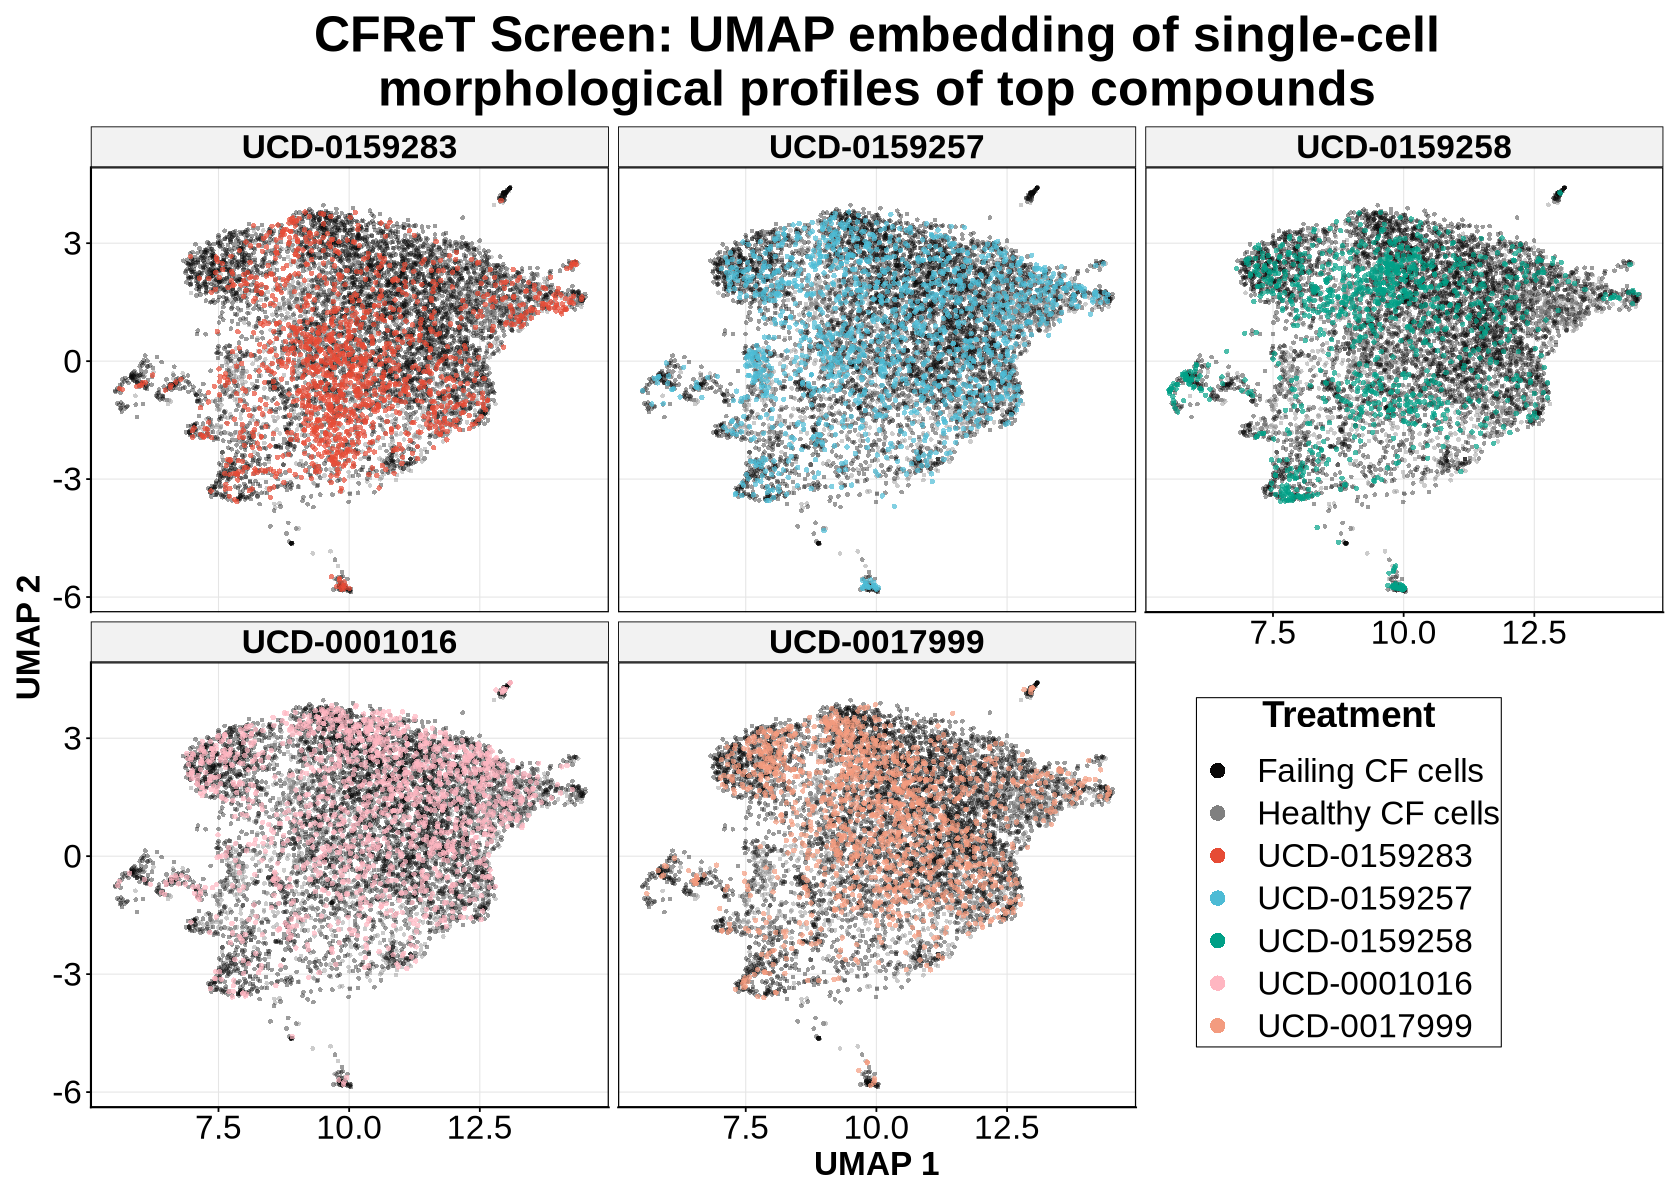

In [8]:
# figure rendering for notebook
height <- 10
width <- 14
options(repr.plot.width = width, repr.plot.height = height, dpi = 500)

# Keep original facet_label values and convert to factor
plot_df <- plot_df %>%
  mutate(
    facet_label = factor(facet_treatment, levels = top_trt)
  )


# Remove any rows with NA facet_label if they exist
plot_df <- plot_df %>%
  filter(!is.na(facet_label))

umap_plot <- ggplot(plot_df, aes(x = UMAP_1, y = UMAP_2, color = treatment_label)) +
  # Plot controls first (background layer)
  geom_point(
    data = filter(plot_df, Metadata_treatment %in% c(poscon_trt, negcon_trt)),
    alpha = 0.4, 
    size = 1,
    shape = 16
  ) +
  geom_point(
    data = filter(plot_df, Metadata_treatment %in% top_trt),
    alpha = 0.7, 
    size = 1.2,
    shape = 16
  ) +
  facet_wrap(~ facet_label, nrow = 2, ncol = 3) + 
  scale_color_manual(
    values = treatment_colors,
    name = "Treatment",
    breaks = c("DMSO (Failing)", "DMSO (Healthy)", top_trt),
    labels = c("Failing CF cells", "Healthy CF cells", top_trt)
  ) +
  labs(
    title = "CFReT Screen: UMAP embedding of single-cell\nmorphological profiles of top compounds",
    x = "UMAP 1",
    y = "UMAP 2"
  ) +
  theme_cowplot(font_size = 11) + 
  theme(
    # Title and labels
    plot.title = element_text(size = 30, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_text(size = 20, color = "black"),
    
    # Facet labels
    strip.text = element_text(size = 20, face = "bold", color = "black"),
    strip.background = element_rect(fill = "gray95", color = "black", linewidth = 0.5),
    
    # Legend - position in the 6th facet spot
    legend.position = c(0.8, 0.25),
    legend.justification = c(0.5, 0.5),
    legend.title = element_text(size = 22, face = "bold", hjust = 0.5),
    legend.text = element_text(size = 20),
    legend.key.size = unit(0.9, "cm"),
    legend.background = element_rect(fill = "white", color = "black", linewidth = 0.3),
    
    # Panel
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.7),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    
    # Overall
    plot.background = element_rect(fill = "white", color = NA),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  guides(color = guide_legend(override.aes = list(size = 4, alpha = 1)))

# # save the plot as a high-resolution PNG and PDF
# ggsave(
#   filename = "./results/cfret-screen/cfret_umap_of_top_treatments.png",
#   plot = umap_plot,
#   width = width,
#   height = height,
#   units = "in",
#   dpi = 600,
#   bg = "white"
# )

umap_plot

## Now plotting umap including worst performing treatment

In [11]:
# Update top_trt to include the worst compound
top_trt = c("UCD-0159283", "UCD-0159257", "UCD-0159258", "UCD-0001016", "UCD-0017999", "UCD-0001844")

# RE-CREATE the data with the bad compound included
# First, separate controls and treatments
controls_df <- cfret_umap_df %>%
  filter(Metadata_treatment %in% c(poscon_trt, negcon_trt))

treatments_df <- cfret_umap_df %>%
  filter(Metadata_treatment %in% top_trt)  # Now includes UCD-0001844

# Create a column to identify which treatment each facet should show
# For controls, replicate them for each top treatment
controls_expanded <- map_dfr(top_trt, function(trt) {
  controls_df %>%
    mutate(facet_treatment = trt)
})

# For treatments, the facet_treatment is their own treatment
treatments_df <- treatments_df %>%
  mutate(facet_treatment = Metadata_treatment)

# Combine them
plot_df <- bind_rows(controls_expanded, treatments_df)

# Create better treatment labels - rename worst compound in BOTH columns
# Also create a simplified category for coloring
plot_df <- plot_df %>%
  mutate(
    treatment_label = case_when(
      Metadata_treatment == "DMSO_heart_9" ~ "DMSO (Failing)",
      Metadata_treatment == "DMSO_heart_11" ~ "DMSO (Healthy)",
      Metadata_treatment == "UCD-0001844" ~ "UCD-0001844 (worst)",
      TRUE ~ Metadata_treatment
    ),
    # Also rename in facet_label for the facet titles
    facet_label = case_when(
      facet_treatment == "UCD-0001844" ~ "UCD-0001844 (worst)",
      TRUE ~ facet_treatment
    ),
    # Create a color category - all treatments get same color
    color_category = case_when(
      Metadata_treatment == "DMSO_heart_9" ~ "DMSO (Failing)",
      Metadata_treatment == "DMSO_heart_11" ~ "DMSO (Healthy)",
      TRUE ~ "Treatment"
    )
  )

# Setting custom colors - simplified 3-color scheme
treatment_colors <- c(
  "DMSO (Failing)" = "#d95f02",    # Orange/red
  "DMSO (Healthy)" = "#1b9e77",    # Green
  "Treatment" = "#7570b3"          # Purple
)

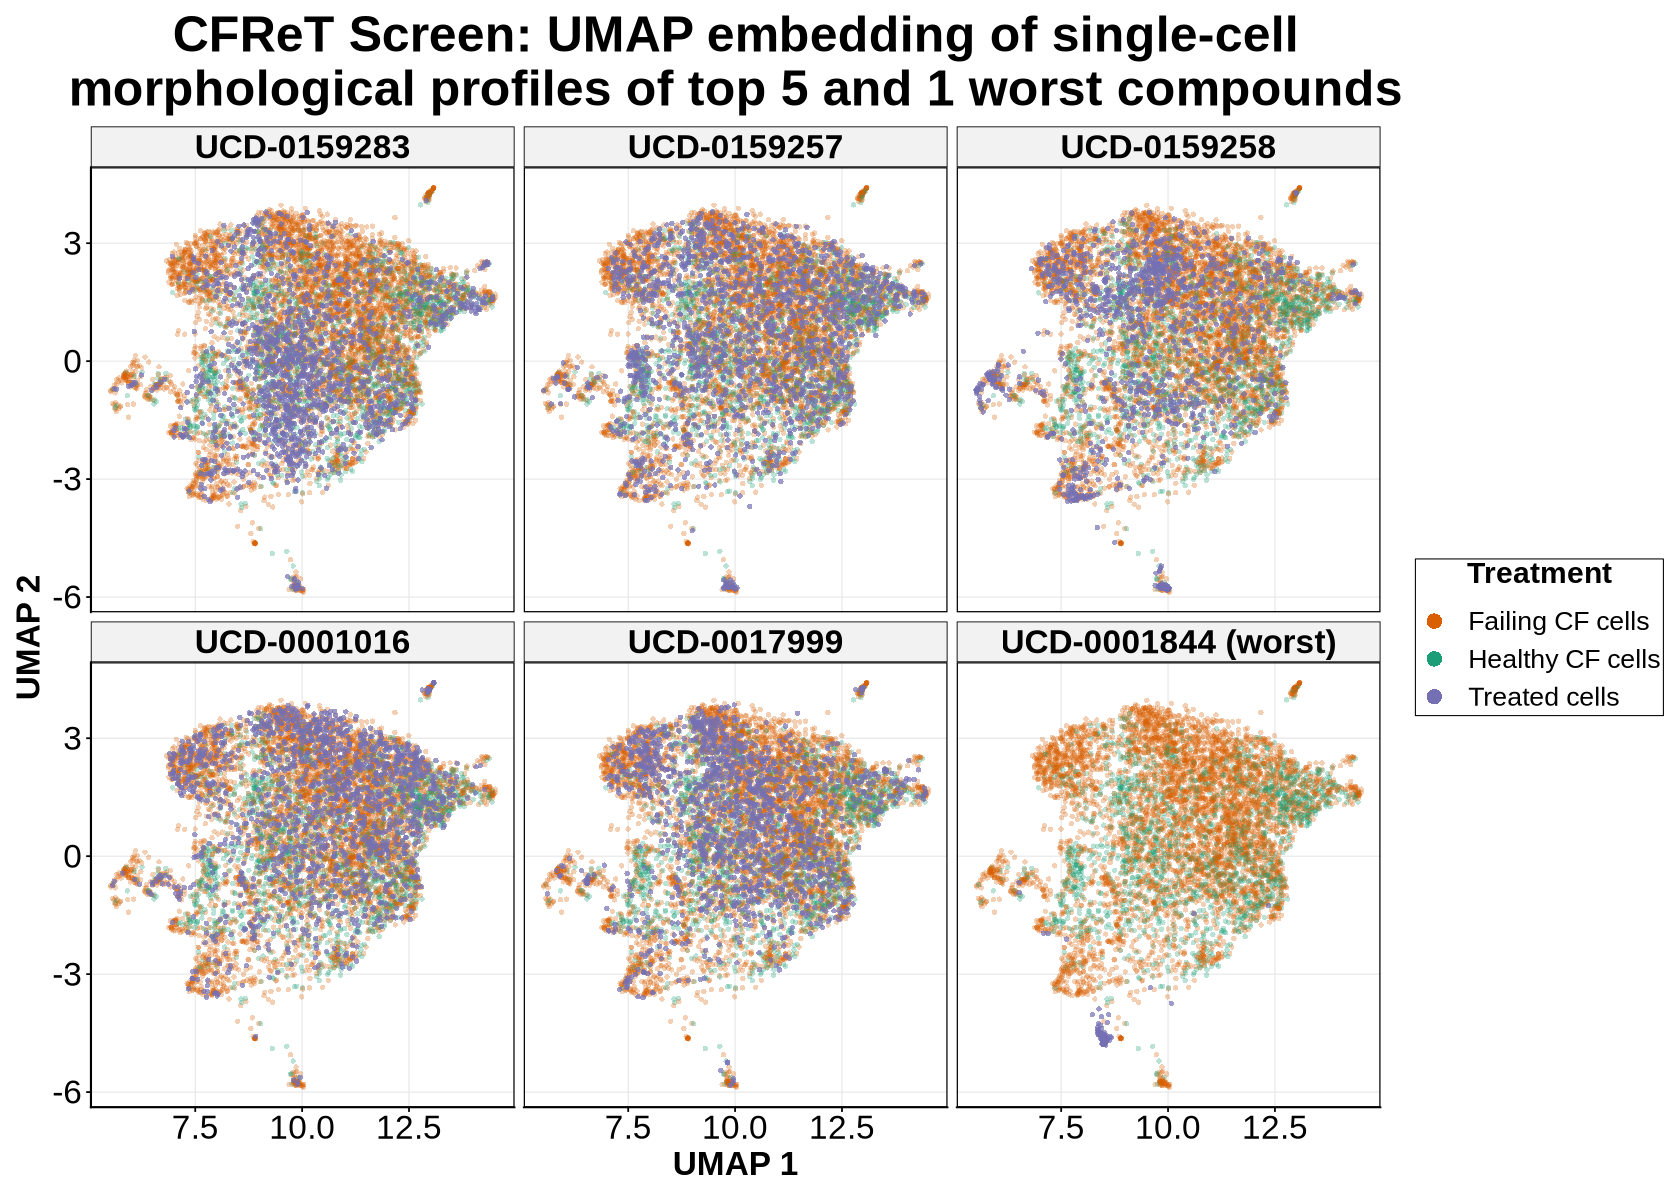

In [18]:
# figure rendering for notebook
height <- 10
width <- 14
options(repr.plot.width = width, repr.plot.height = height, dpi = 500)

# Update top_trt_display to include the renamed worst compound
top_trt_display = c("UCD-0159283", "UCD-0159257", "UCD-0159258", "UCD-0001016", "UCD-0017999", "UCD-0001844 (worst)")

# Keep original facet_label values and convert to factor with updated levels
plot_df <- plot_df %>%
  mutate(
    facet_label = factor(facet_label, levels = top_trt_display)
  )

# Remove any rows with NA facet_label if they exist
plot_df <- plot_df %>%
  filter(!is.na(facet_label))

# Shuffle points for fair plotting
set.seed(42)
plot_df <- plot_df %>%
  slice_sample(prop = 1)

umap_w_bad_treatment_plot <- ggplot(plot_df, aes(x = UMAP_1, y = UMAP_2, color = color_category)) +
  # Plot controls first as lighter background layer
  geom_point(
    data = filter(plot_df, color_category %in% c("DMSO (Failing)", "DMSO (Healthy)")),
    alpha = 0.3,   # Much lighter for background
    size = 1.2,    # Slightly smaller
    shape = 16
  ) +
  # Plot treated points on top with higher visibility
  geom_point(
    data = filter(plot_df, color_category == "Treatment"),
    alpha = 0.7,   # More opaque to stand out
    size = 1.2,    # Slightly larger
    shape = 16
  ) +
  facet_wrap(~ facet_label, nrow = 2, ncol = 3) + 
  scale_color_manual(
    values = treatment_colors,
    name = "Treatment",
    breaks = c("DMSO (Failing)", "DMSO (Healthy)", "Treatment"),
    labels = c("Failing CF cells", "Healthy CF cells", "Treated cells")
  ) +
  labs(
    title = "CFReT Screen: UMAP embedding of single-cell\nmorphological profiles of top 5 and 1 worst compounds",
    x = "UMAP 1",
    y = "UMAP 2"
  ) +
  theme_cowplot(font_size = 11) + 
  theme(
    # Title and labels
    plot.title = element_text(size = 30, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_text(size = 20, color = "black"),
    
    # Facet labels
    strip.text = element_text(size = 20, face = "bold", color = "black"),
    strip.background = element_rect(fill = "gray95", color = "black", linewidth = 0.5),
    
    # Legend - position on the right side outside plot area
    legend.position = "right",
    legend.justification = "center",
    legend.title = element_text(size = 18, face = "bold", hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.key.size = unit(0.8, "cm"),
    legend.background = element_rect(fill = "white", color = "black", linewidth = 0.3),
    legend.box.margin = margin(0, 0, 0, 10),
    
    # Panel
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.7),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    
    # Overall
    plot.background = element_rect(fill = "white", color = NA),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  guides(color = guide_legend(override.aes = list(size = 4, alpha = 1)))

# save the plot as a high-resolution PNG and PDF
ggsave(
  filename = "./results/cfret-screen/cfret_umap_of_top_treatments_and_bad.png",
  plot = umap_w_bad_treatment_plot,
  width = width,
  height = height,
  units = "in",
  dpi = 600,
  bg = "white"
)

umap_w_bad_treatment_plot